# Seasons and drivers

In this notebook we try and extract the effect of seasons and drivers using signal analysis techniques.

## Setup

### Load modules

In [2]:
import sys

import h5py
import cmocean.cm
import datacube
import geopandas as gpd
import matplotlib.animation
import matplotlib.colors
import matplotlib.patches
import numpy as np
import scipy.cluster
import scipy.ndimage.filters
import sklearn.cluster
import sklearn.decomposition
import sklearn.pipeline
import sklearn.preprocessing
import statsmodels.tsa.stattools
from matplotlib import pyplot as plt
from scipy import optimize as opt
from tqdm.notebook import tqdm
import pandas as pd
import xarray
from statsmodels.tsa.seasonal import STL

sys.path.insert(1, "../Scripts")
import dea_plotting
import mattplot

%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)

### Load the data

This was generated in LoadWaterbodies.ipynb.

In [4]:
waterbodies = gpd.read_file('waterbodies_joined_drainage.shp').to_crs('EPSG:3577')
waterbodies = waterbodies.set_index('UID')
history_file = h5py.File('interpolated_waterbodies_by_division.h5', mode='r')
dates = pd.to_datetime([l.decode('ascii') for l in history_file['dates']])

Download climate data, if you need to.

In [5]:
%%bash
# wget https://stateoftheocean.osmc.noaa.gov/atm/data/soi.nc
# wget https://stateoftheocean.osmc.noaa.gov/sur/data/dmi.nc
# wget ftp://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.aao.index.b790101.current.ascii

Unload all python modules, if you experience any issues.


Then read them in and convert to a daily time series.

In [6]:
soi = xarray.open_dataset('soi.nc').SOI
soi = pd.DataFrame({'SOI': soi.to_pandas()})
soi.index.name = 'Date'
soi.index = np.array(soi.index).astype('datetime64[D]')

In [7]:
dmi = xarray.open_dataarray('dmi.nc')
dmi = pd.DataFrame({'DMI': dmi.to_pandas()})
dmi.index.name = 'Date'
dmi.index = np.array(dmi.index).astype('datetime64[D]')

In [8]:
aao = pd.read_csv('norm.daily.aao.index.b790101.current.ascii', sep='\s+', names=['Year', 'Month', 'Day', 'AAO'], skiprows=[8885])
# 8885 has a bunch of asterisks instead of the AAO.
aao_dates = pd.to_datetime(aao[['Year', 'Month', 'Day']])
aao.index = aao_dates

In [9]:
rolling_aao = aao.AAO.rolling(28).mean()
rolling_soi = soi.SOI.rolling(28).mean()
rolling_dmi = dmi.DMI.rolling(28).mean()

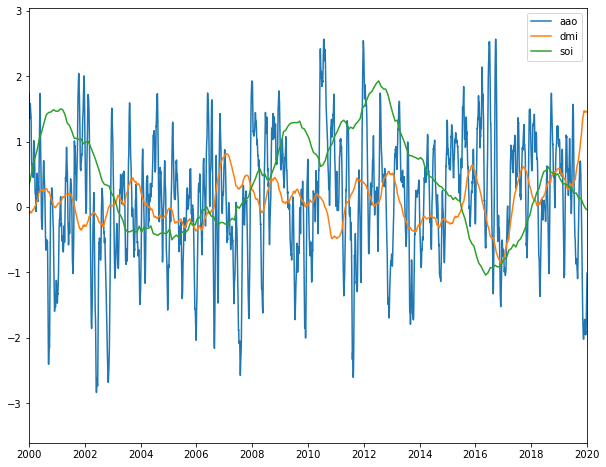

In [11]:
plt.plot(aao.index, rolling_aao, label='aao')
plt.plot(dmi.index, rolling_dmi, label='dmi')
plt.plot(soi.index, rolling_soi, label='soi')
plt.xlim(pd.to_datetime('2000'), pd.to_datetime('2020'))
plt.legend()

## Trends

Let's examine the area-weighted means of each region.

In [12]:
area_weighted_means = {}

for division in tqdm(history_file):
    if division in {'None', 'dates'}:
        continue
        
    wbs = waterbodies.loc[[u.decode('ascii') for u in history_file[division]['uid'][()]]]
    areas = wbs.area
    total = 0
    divider = 0
    for i in range(0, len(history_file[division]['pc_wet']), 10000):
        total += np.nan_to_num(history_file[division]['pc_wet'][i:i + 10000]).T @ areas.values[i:i+10000]
        divider += areas.values[i:i + 10000].sum()
    area_weighted_means[division] = total / divider

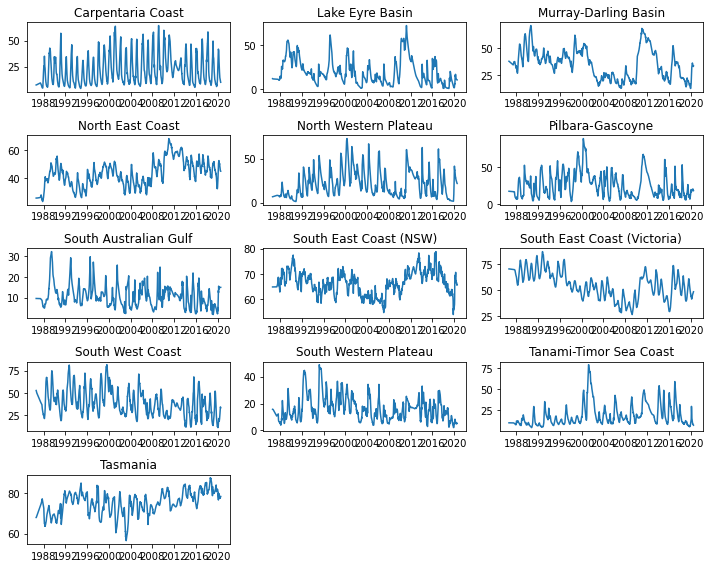

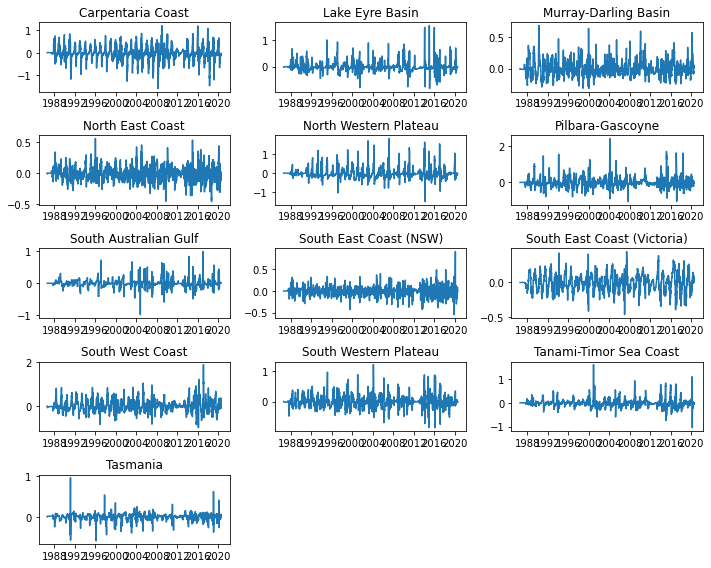

In [13]:
plt.figure(figsize=(10, 8))
divisions = sorted(area_weighted_means)
for i in range(13):
    ax = plt.subplot(5, 3, i + 1)
    ax.set_title(divisions[i])
    ax.plot(dates, area_weighted_means[divisions[i]])
plt.tight_layout()

plt.figure(figsize=(10, 8))
for i in range(13):
    ax = plt.subplot(5, 3, i + 1)
    ax.set_title(divisions[i])
    ax.plot(dates, np.gradient(area_weighted_means[divisions[i]]))
plt.tight_layout()

The main driver here is clearly seasonal. This should be reflected in the SAD curves:

In [14]:
seasons = {
    'Summer': dates.month.isin({12, 1, 2}),
    'Autumn': dates.month.isin({3, 4, 5}),
    'Winter': dates.month.isin({6, 7, 8}),
    'Spring': dates.month.isin({9, 10, 11}),
}

In [15]:
season_names = ['Summer', 'Autumn', 'Winter', 'Spring']
season_colours = ['red', 'orange', 'blue', 'limegreen']

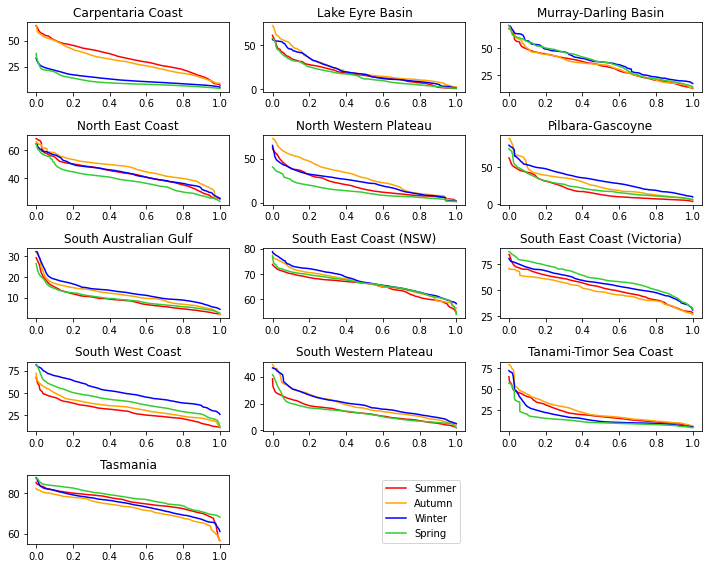

In [16]:
plt.figure(figsize=(10, 8))
divisions = sorted(area_weighted_means)
for i in range(13):
    ax = plt.subplot(5, 3, i + 1)
    ax.set_prop_cycle('color', season_colours)
    ax.set_title(divisions[i])
    for season in season_names:
        ax.plot(np.linspace(0, 1, sum(seasons[season])), np.sort(area_weighted_means[divisions[i]][seasons[season]])[::-1], label=season)
h1, l1 = ax.get_legend_handles_labels()
ax = plt.subplot(5, 3, i + 2)
ax.legend(h1, l1)
ax.axis('off')
plt.tight_layout()

# plt.figure(figsize=(10, 8))
# for i in range(13):
#     ax = plt.subplot(5, 3, i + 1)
#     ax.set_title(divisions[i])
#     ax.plot(dates, np.gradient(area_weighted_means[divisions[i]]))
# plt.tight_layout()

We can see that the seasons are way more influential in some regions (Carpentaria Coast, North East Coast, South West Coast...) than others (e.g. South East Coast [NSW]), and also that the seasonal variation affects different parts of the SAD curve differently (e.g. Lake Eyre Basin mainly has its short-duration events during winter and autumn).

Let's try using `statsmodels` to [pull out the seasonal trend](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html).

In [59]:
stl_results = {}
for division, mean in tqdm(area_weighted_means.items()):
    stl = STL(mean, period=365, seasonal=27, trend=365 * 3)
    res = stl.fit()
    stl_results[division] = res

In [55]:
stl_results_grad = {}
for division, mean in tqdm(area_weighted_means.items()):
    stl = STL(np.gradient(mean), period=365, seasonal=27, trend=365 * 3)
    res = stl.fit()
    stl_results_grad[division] = res

In [18]:
# Adapted from statsmodels.tsa.seasonal.DecomposeResult.plot.
def plot(self, observed=True, seasonal=True, trend=True, resid=True, weights=False):
    series = [(self._observed, 'Observed')] if observed else []
    series += [(self.trend, 'trend')] if trend else []
    series += [(self.seasonal, 'seasonal')] if seasonal else []
    series += [(self.resid, 'residual')] if resid else []
    series += [(self.weights, 'weights')] if weights else []

    if isinstance(self._observed, (pd.DataFrame, pd.Series)):
        nobs = self._observed.shape[0]
        xlim = self._observed.index[0], self._observed.index[nobs - 1]
    else:
        xlim = (0, self._observed.shape[0] - 1)

    fig, axs = plt.subplots(len(series), 1)
    for i, (ax, (series, def_name)) in enumerate(zip(axs, series)):
        if def_name != 'residual':
            ax.plot(series)
        else:
            ax.plot(series, marker='.', linestyle='none')
            ax.plot(xlim, (0, 0), color='#000000', zorder=-3)
        name = getattr(series, 'name', def_name)
        if def_name != 'Observed':
            name = name.capitalize()
        title = ax.set_title if i == 0 and observed else ax.set_ylabel
        title(name)
        ax.set_xlim(xlim)

    fig.tight_layout()
    return fig

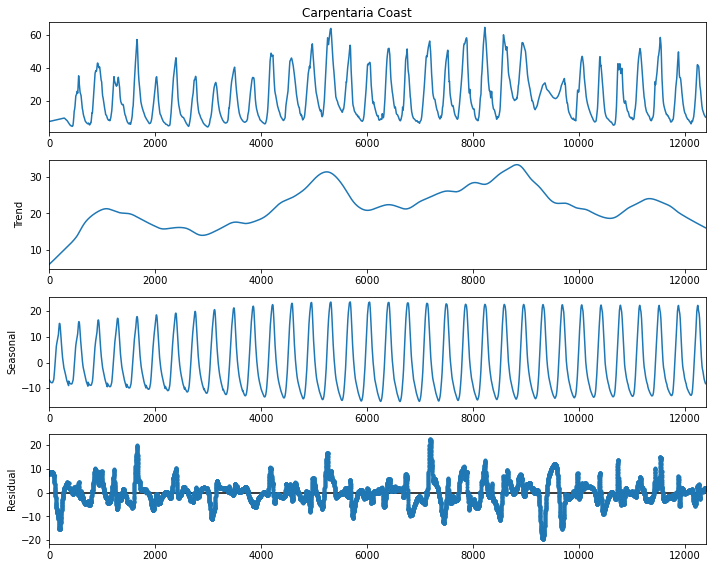

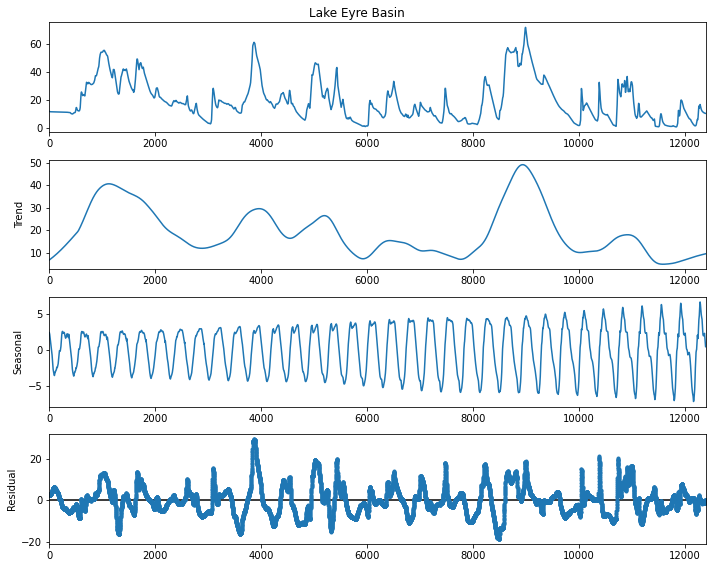

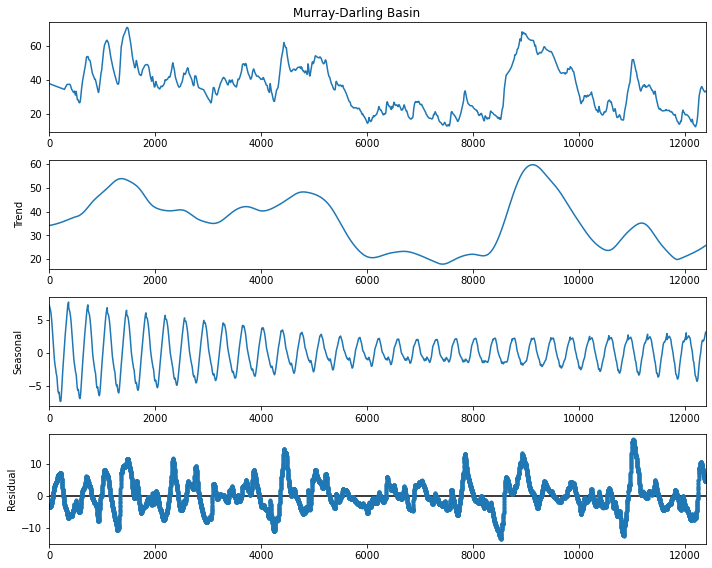

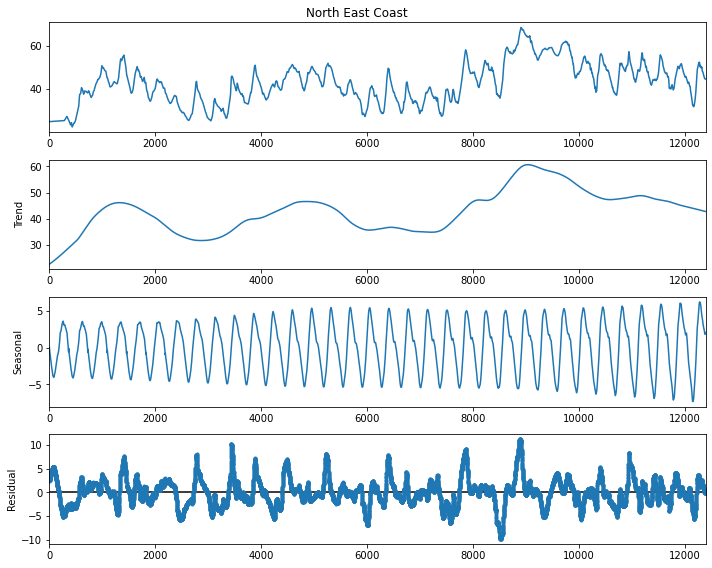

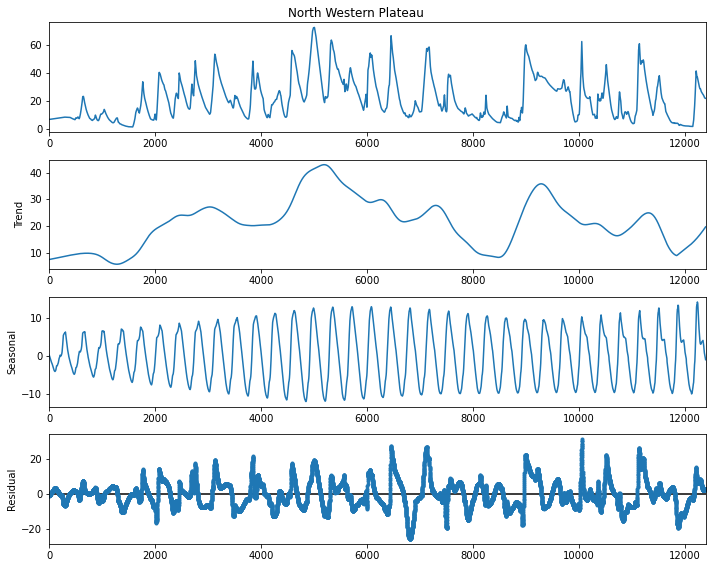

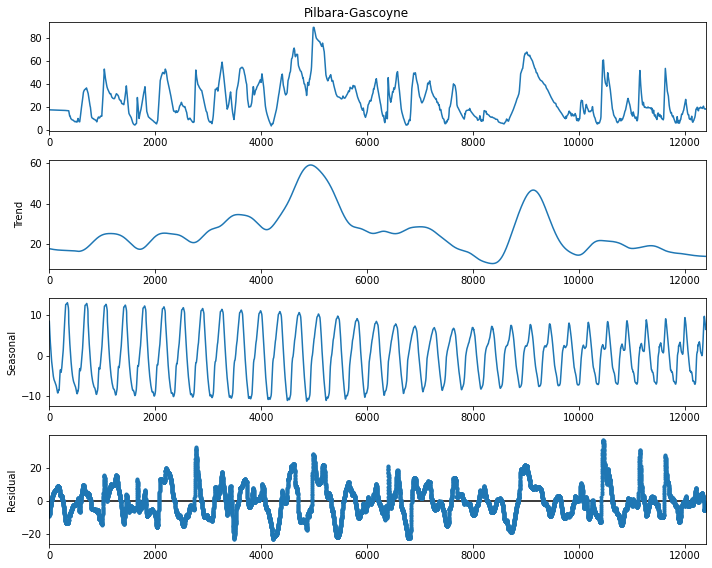

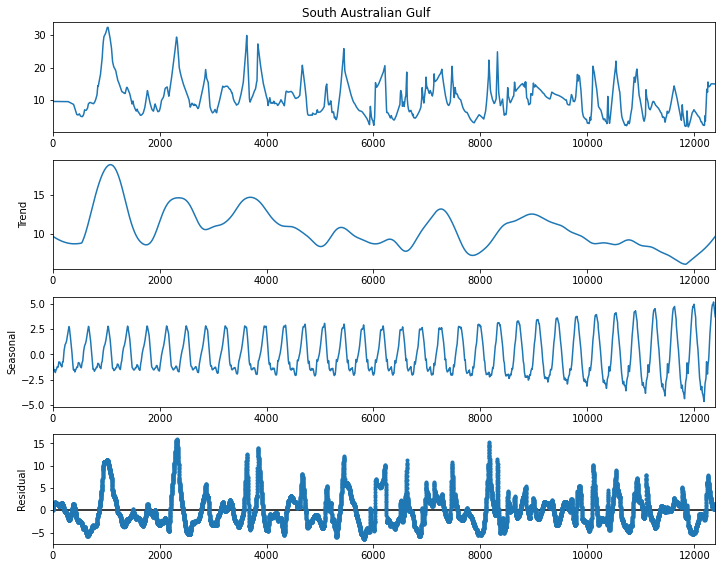

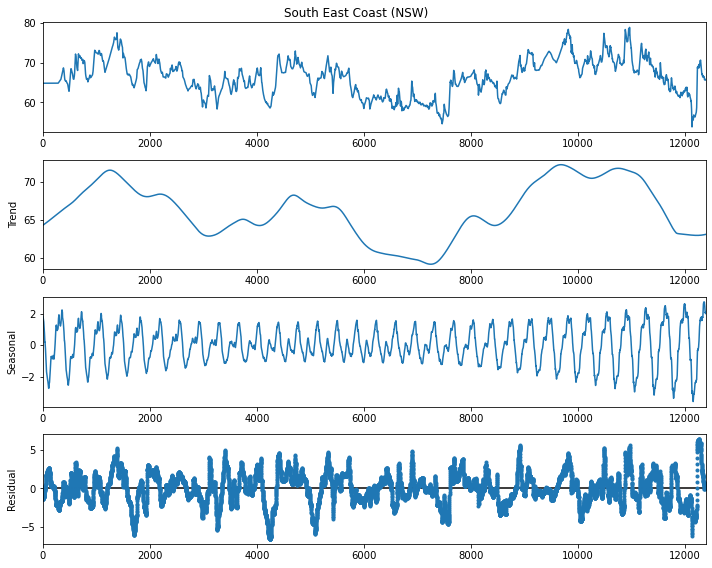

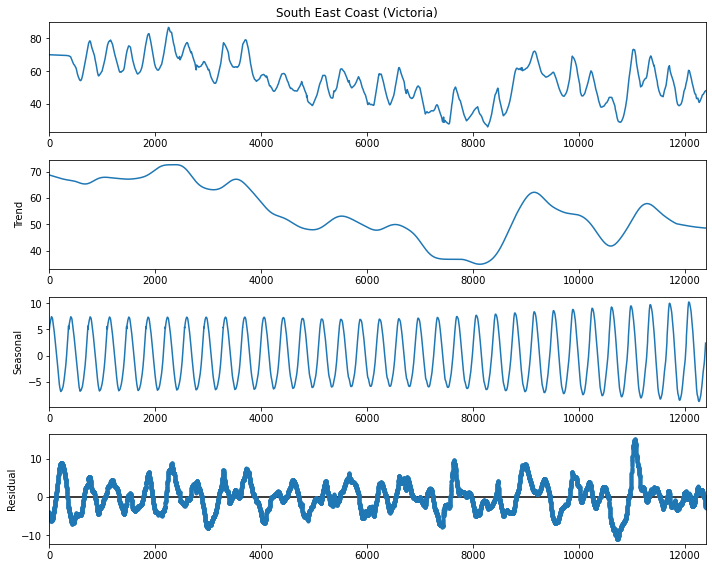

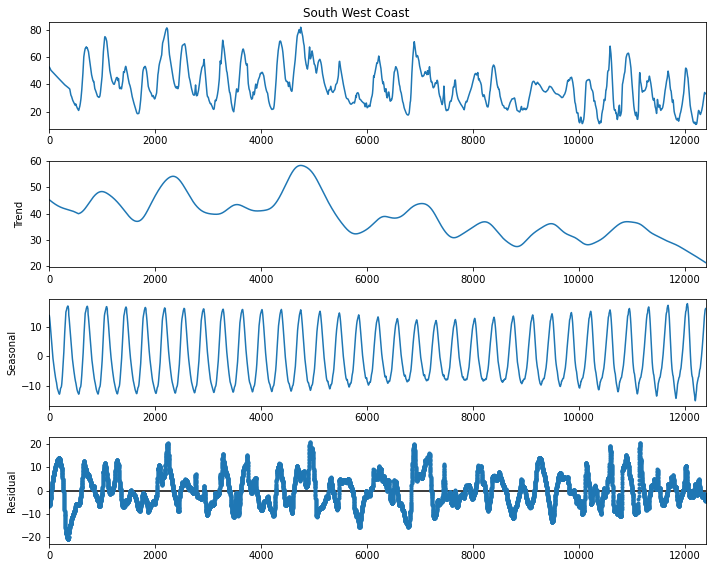

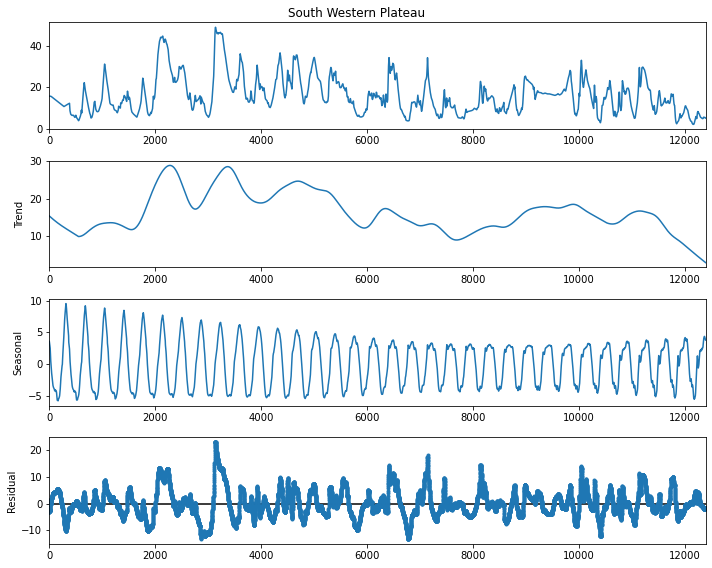

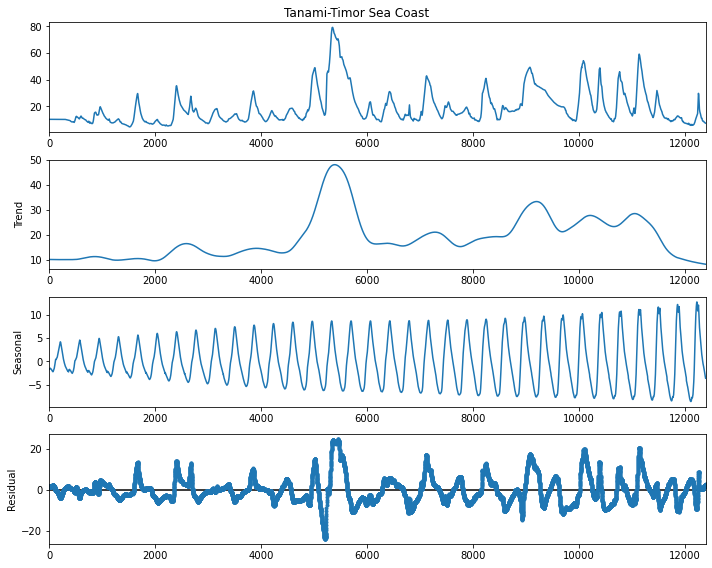

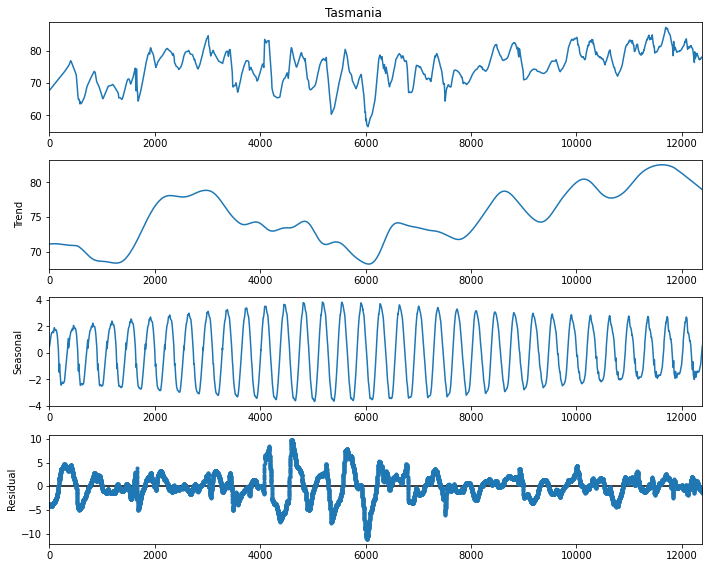

In [19]:
for division, res in stl_results.items():
    fig = plot(res)
    fig.suptitle(division)
    fig.axes[0].set_title('')
    plt.show()

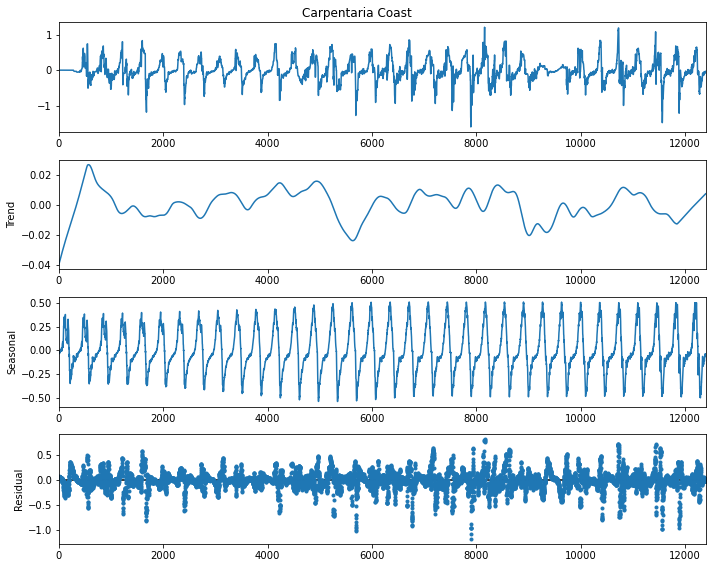

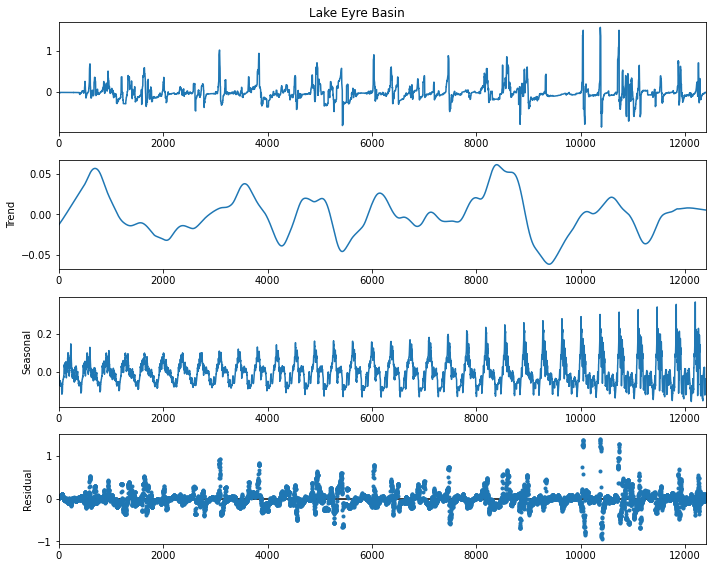

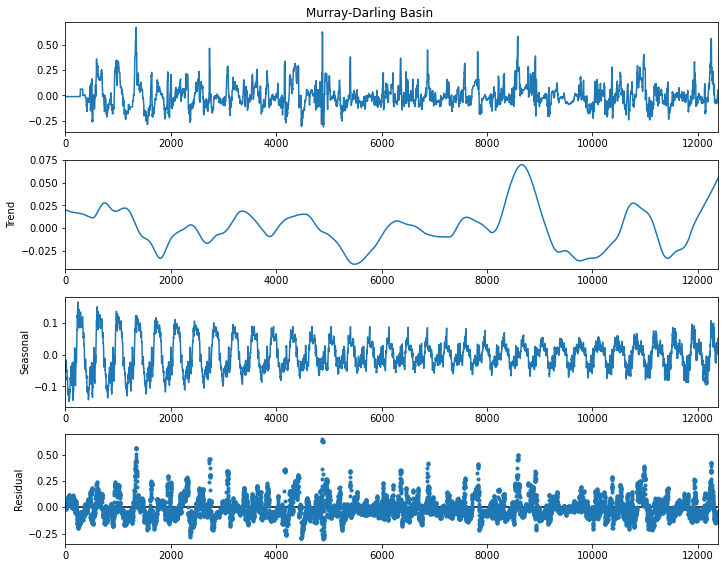

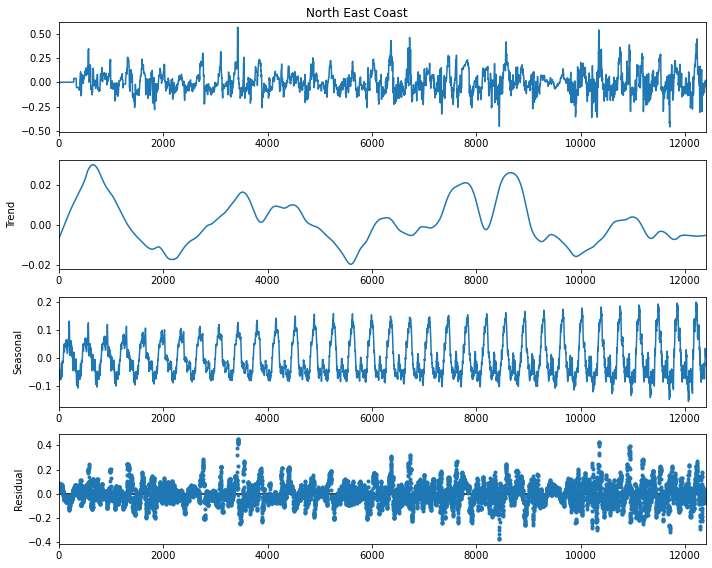

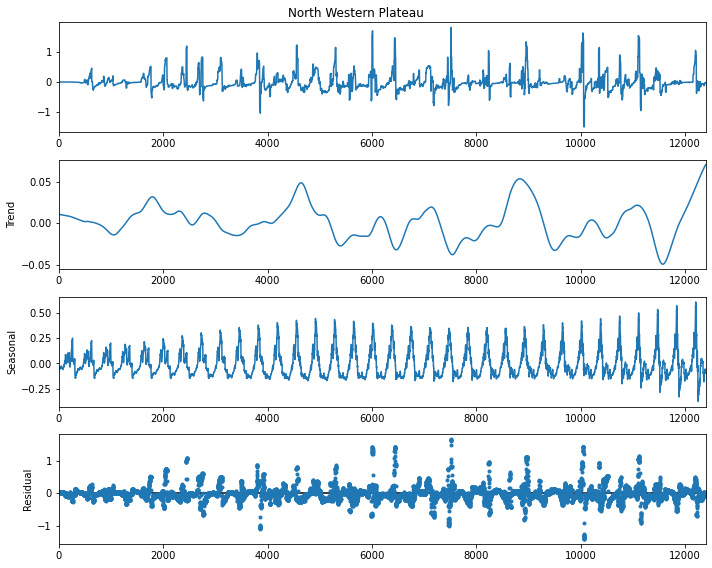

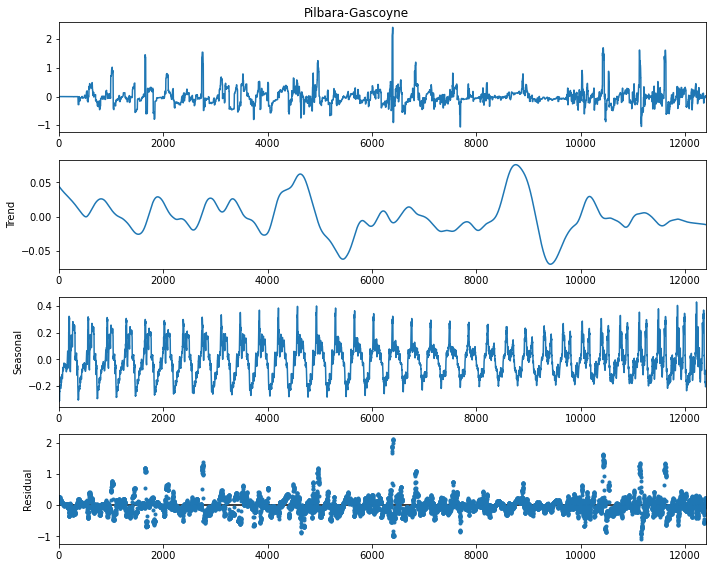

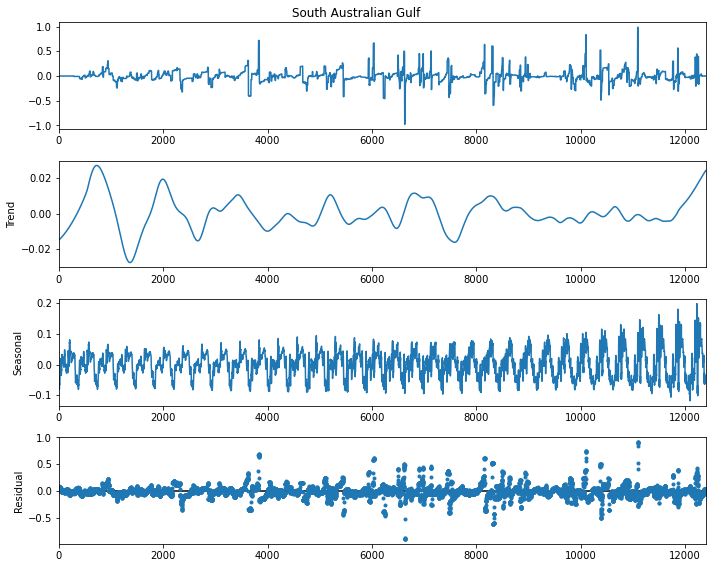

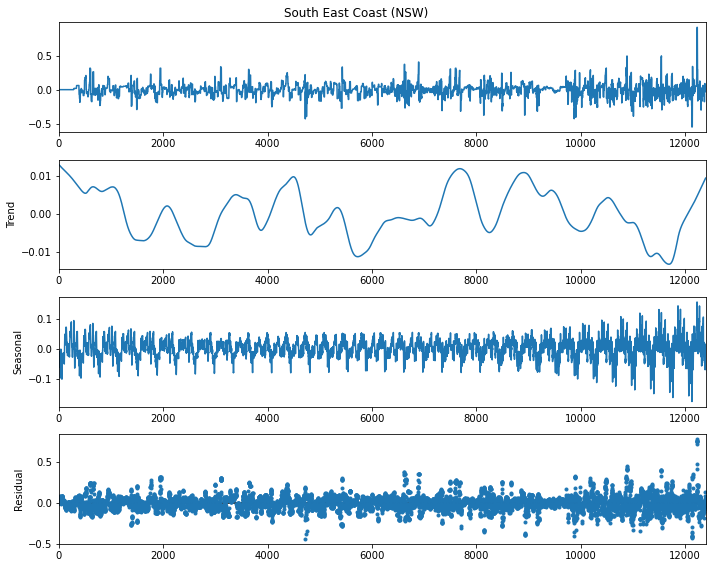

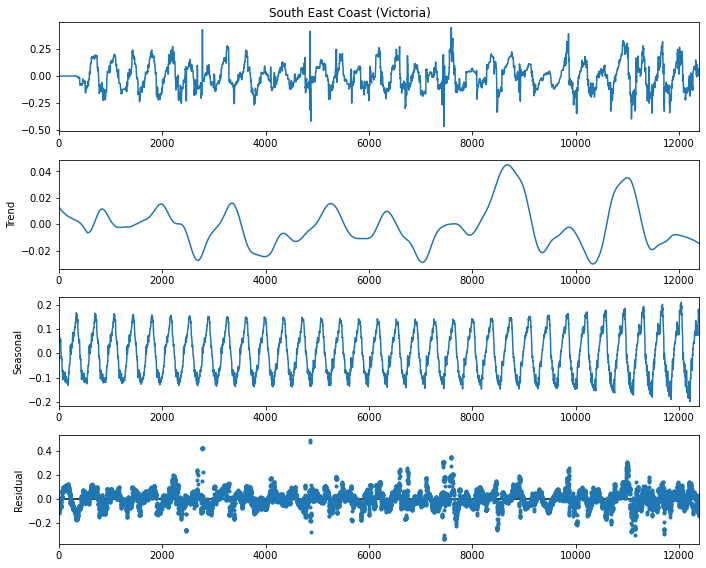

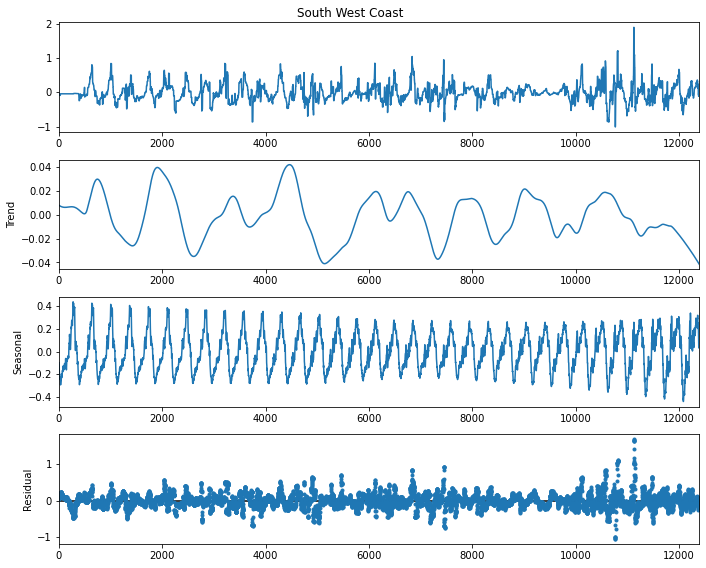

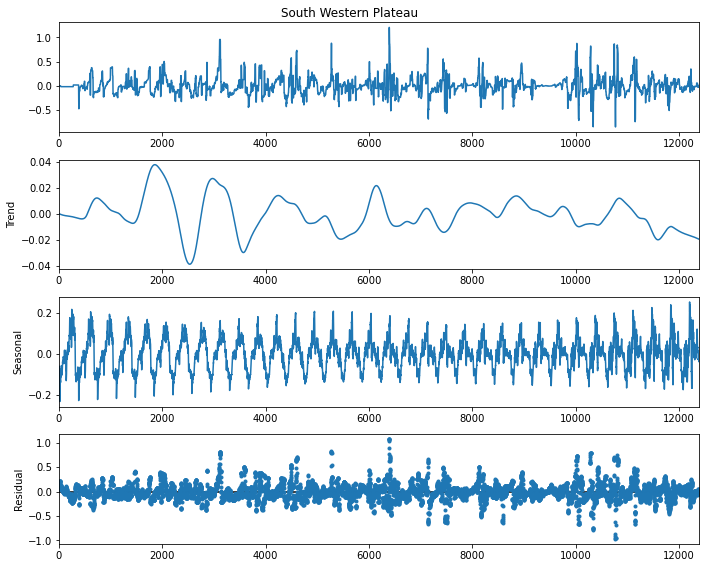

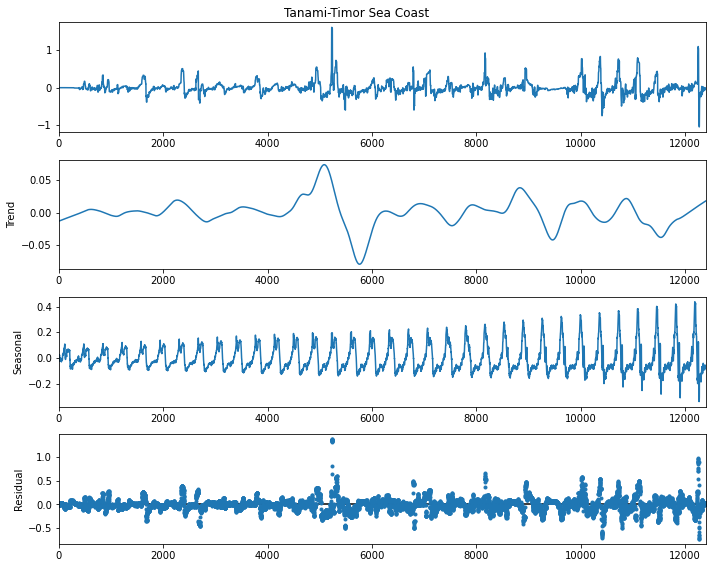

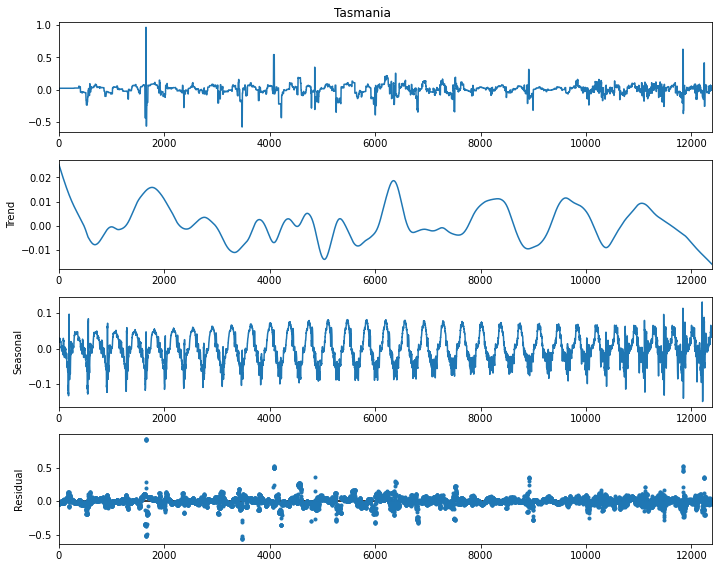

In [58]:
for division, res in stl_results_grad.items():
    fig = plot(res)
    fig.suptitle(division)
    fig.axes[0].set_title('')
    plt.show()

We can also look at any seasonal variation in the climate indicators.

In [20]:
soi_vals = soi.resample('1D').mean().reindex(dates).ffill().bfill().SOI
aao_vals = aao.resample('1D').mean().reindex(dates).ffill().bfill().AAO
dmi_vals = dmi.resample('1D').mean().reindex(dates).ffill().bfill().DMI

climate = np.stack([
    soi_vals,
    aao_vals,
    dmi_vals,]).T

climate = climate - climate.mean(axis=0)
climate /= climate.std()

In [21]:
stl_soi = STL(soi_vals, period=365, seasonal=27, trend=367).fit()
stl_aao = STL(aao_vals, period=365, seasonal=27, trend=367).fit()
stl_dmi = STL(dmi_vals, period=365, seasonal=27, trend=367).fit()

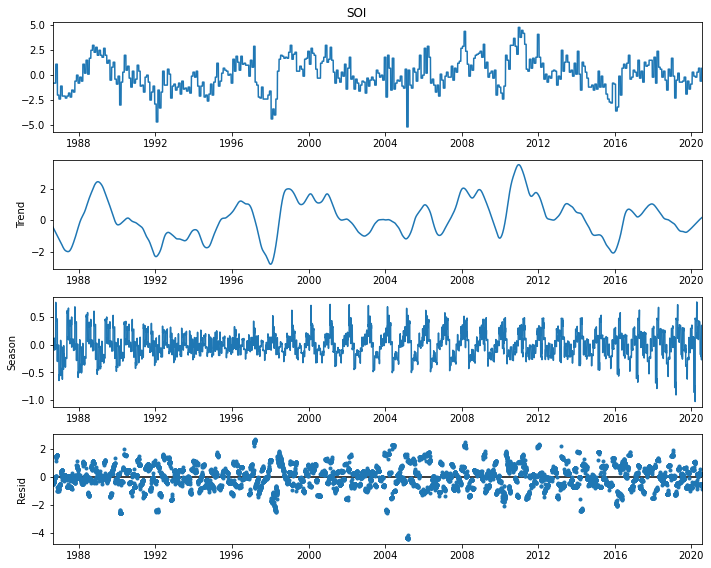

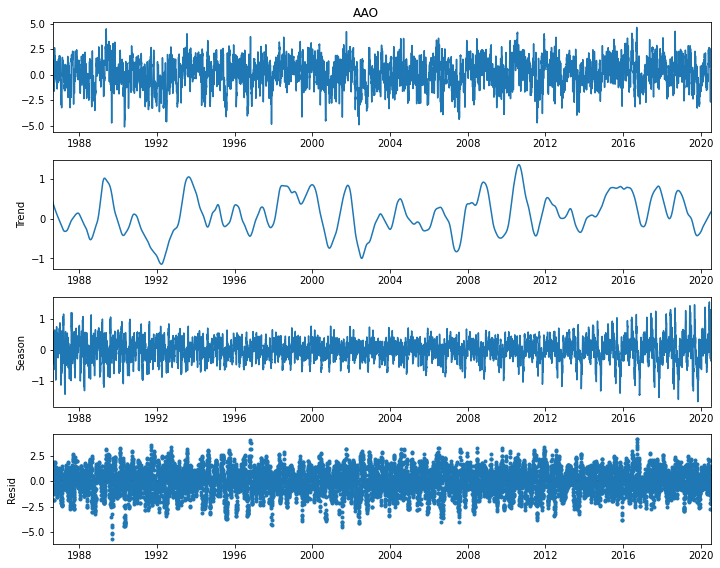

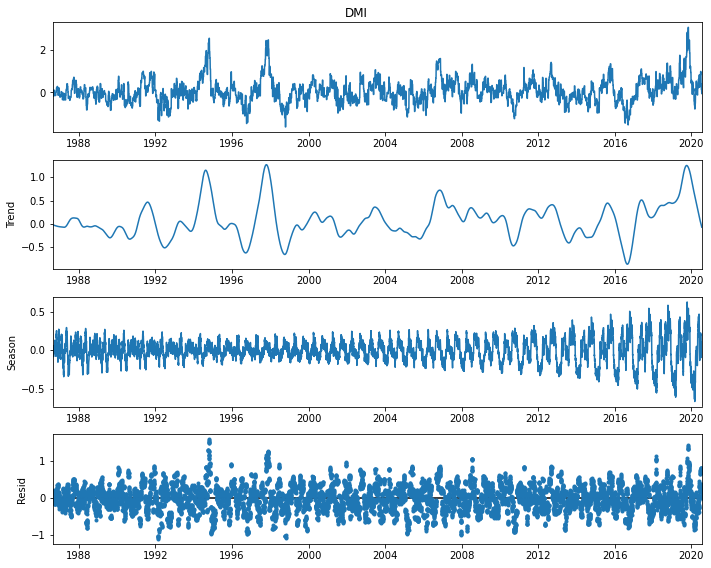

In [22]:
fig = plot(stl_soi)
fig.suptitle('SOI')
fig.axes[0].set_title('')
plt.show()
fig = plot(stl_aao)
fig.suptitle('AAO')
fig.axes[0].set_title('')
plt.show()
fig = plot(stl_dmi)
fig.suptitle('DMI')
fig.axes[0].set_title('')
plt.show()

## Predicting the residuals

Let's characterise the means by how predictable they are based on the climate drivers. As input, take the climate driver trends, seasons, and residuals, for a total of 9 features. Output the trends, seasons, and residuals of the means. We will not centre the data.

In [62]:
climate_features = np.stack([
    stl_soi.resid,
    stl_aao.resid,
    stl_dmi.resid,
    stl_soi.seasonal,
    stl_aao.seasonal,
    stl_dmi.seasonal,
    stl_soi.trend,
    stl_aao.trend,
    stl_dmi.trend,
]).T

In [63]:
targets = {division: np.stack([res.resid, res.seasonal, res.trend]).T for division, res in stl_results.items()}

In [65]:
regressors = {division: sklearn.linear_model.LinearRegression() for division in targets}
scores = {}
for name, regressor in tqdm(regressors.items()):
    regressor.fit(climate_features, targets[name])
    scores[name] = regressor.score(climate_features, targets[name])

In [77]:
regressors['Tasmania'].coef_.shape

(3, 9)

([<matplotlib.axis.YTick at 0x7ff548bbe358>,
 [Text(0, 0, 'mean residual'),
  Text(0, 0, 'mean seasonal'),
  Text(0, 0, 'mean trend')])

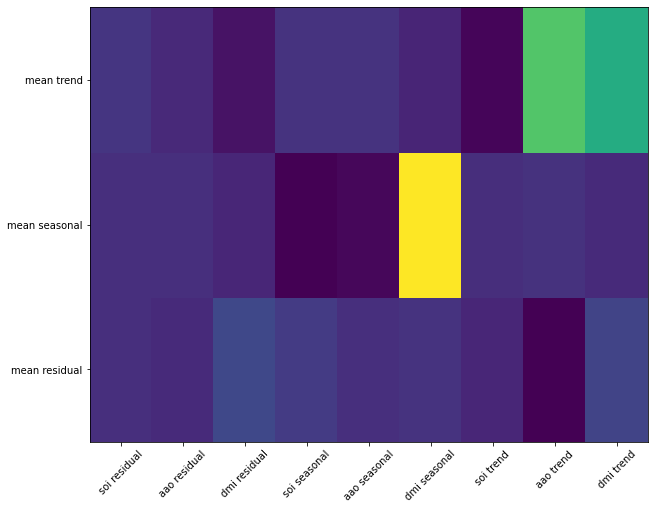

In [83]:
plt.pcolormesh(range(10), range(4), regressors['Tasmania'].coef_)
plt.xticks(np.arange(9) + 0.5, ['soi residual', 'aao residual', 'dmi residual', 'soi seasonal', 'aao seasonal', 'dmi seasonal', 'soi trend', 'aao trend', 'dmi trend'],
           rotation=45)
plt.yticks(np.arange(3) + 0.5, ['mean residual', 'mean seasonal', 'mean trend'])

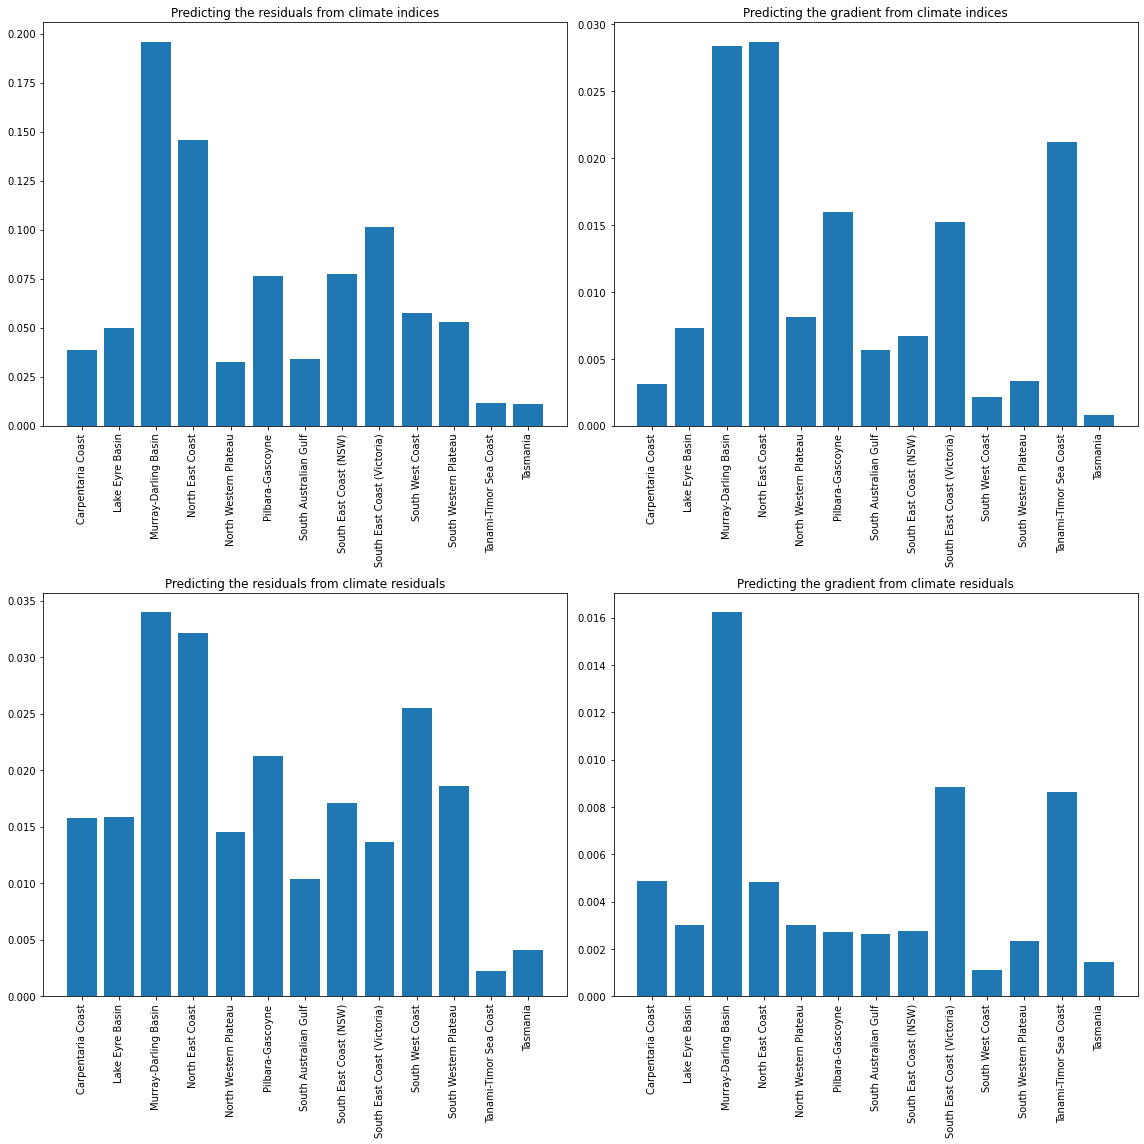

In [28]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.bar(range(len(scores_resid_orig)), [scores_resid_orig[name] for name in sorted(scores_resid_orig)])
plt.xticks(np.arange(len(scores_resid_orig)), sorted(scores_resid_orig), rotation='vertical')
plt.title('Predicting the residuals from climate indices')
plt.subplot(2, 2, 2)
plt.bar(range(len(scores_grad_orig)), [scores_grad_orig[name] for name in sorted(scores_grad_orig)])
plt.xticks(np.arange(len(scores_grad_orig)), sorted(scores_grad_orig), rotation='vertical')
plt.title('Predicting the gradient from climate indices')
plt.subplot(2, 2, 3)
plt.bar(range(len(scores_resid_resid)), [scores_resid_resid[name] for name in sorted(scores_resid_resid)])
plt.xticks(np.arange(len(scores_resid_resid)), sorted(scores_resid_resid), rotation='vertical')
plt.title('Predicting the residuals from climate residuals')
plt.subplot(2, 2, 4)
plt.bar(range(len(scores_grad_resid)), [scores_grad_resid[name] for name in sorted(scores_grad_resid)])
plt.xticks(np.arange(len(scores_grad_resid)), sorted(scores_grad_resid), rotation='vertical')
plt.title('Predicting the gradient from climate residuals')
plt.tight_layout();

We could also look at the gradient and water level vs time of year. Recalling that time of year is an angle, this is a polar plot.

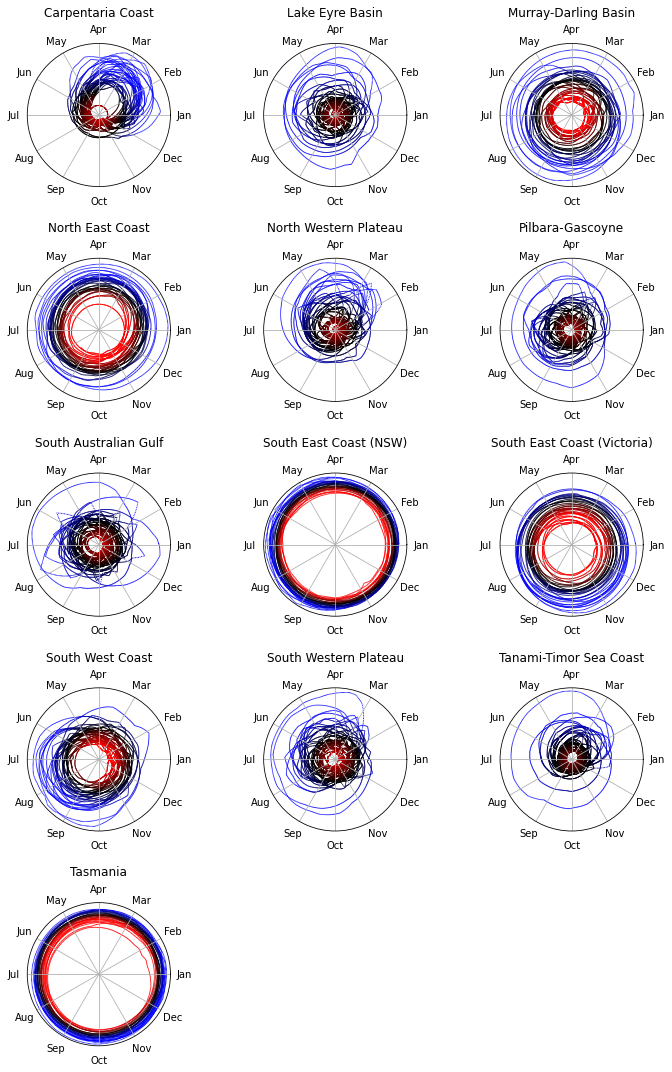

In [150]:
plt.figure(figsize=(10, 15))
for i in range(13):
    ax = plt.subplot(5, 3, i + 1, projection='polar')
    ax.set_title(divisions[i], pad=20)
    mean = area_weighted_means[divisions[i]]
    days = dates.dayofyear
    angles = days / 365 * 2 * np.pi
    ax.scatter(angles, mean, alpha=1, s=1, edgecolor='None', c=(mean - np.mean(mean)) / np.max((mean - np.mean(mean))),
               cmap=matplotlib.colors.LinearSegmentedColormap.from_list('rkb', ['r', 'k', 'b']), vmax=0.5, vmin=-0.5)
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_rticks([0])
    ax.set_yticklabels([''])
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

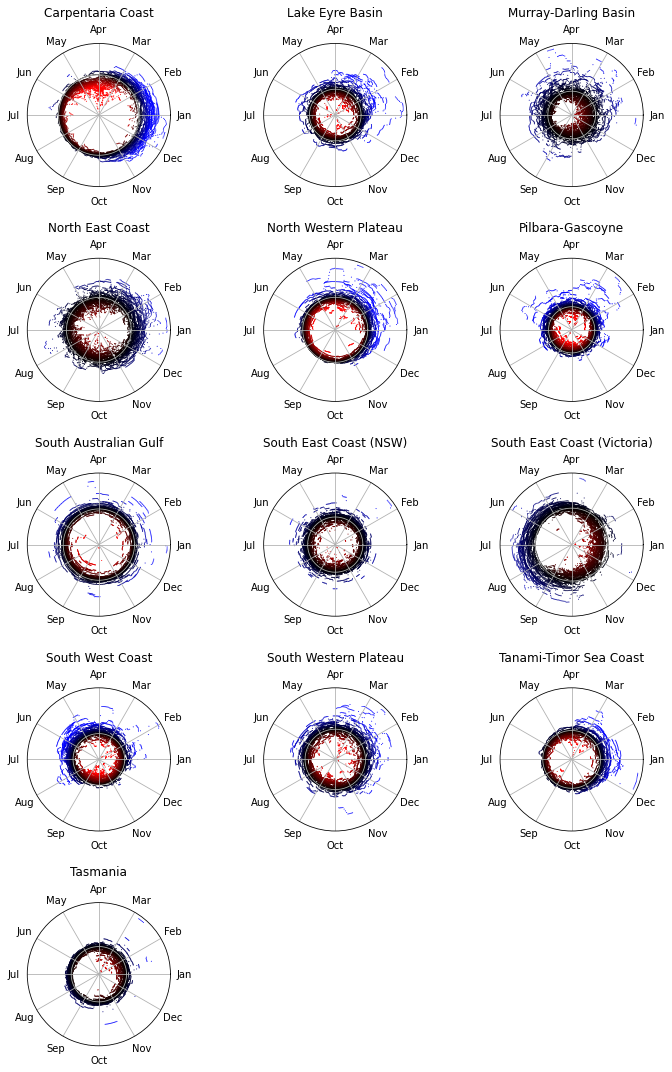

In [145]:
plt.figure(figsize=(10, 15))
for i in range(13):
    ax = plt.subplot(5, 3, i + 1, projection='polar')
    ax.set_title(divisions[i], pad=20)
    grad = np.gradient(area_weighted_means[divisions[i]])
    days = dates.dayofyear
    angles = days / 365 * 2 * np.pi
    ax.scatter(angles, grad, alpha=1, s=1, edgecolor='None', c=grad, cmap=matplotlib.colors.LinearSegmentedColormap.from_list('rkb', ['r', 'k', 'b']), vmax=0.5, vmin=-0.5)
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_rticks([0])
    ax.set_yticklabels([''])
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

But we could also plot the residuals of the STL and see if that's correctly pulled out the seasons and trend. It should look pretty random.

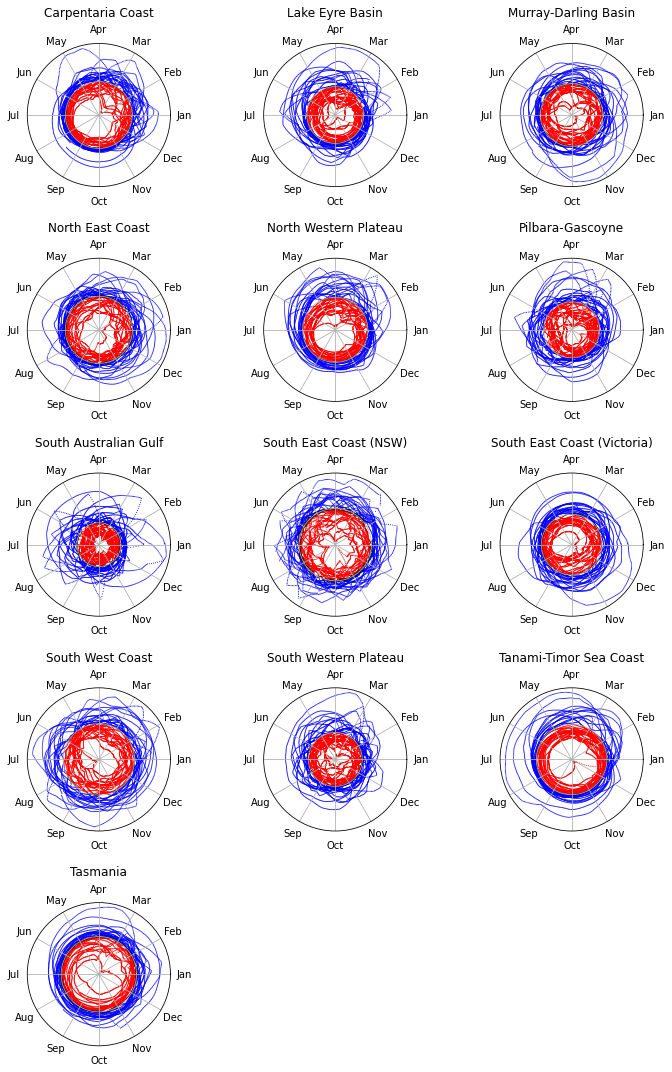

In [152]:
plt.figure(figsize=(10, 15))
for i in range(13):
    ax = plt.subplot(5, 3, i + 1, projection='polar')
    ax.set_title(divisions[i], pad=20)
    grad = np.gradient(area_weighted_means[divisions[i]])
    days = dates.dayofyear
    angles = days / 365 * 2 * np.pi
    resid = stl_results[divisions[i]].resid
    ax.scatter(angles, resid, alpha=1, s=1, edgecolor='None', c=resid, cmap=matplotlib.colors.LinearSegmentedColormap.from_list('rkb', ['r', 'k', 'b']), vmax=0.5, vmin=-0.5)
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_rticks([0])
    ax.set_yticklabels([''])
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

And of course we can plot the seasonality and the trend.

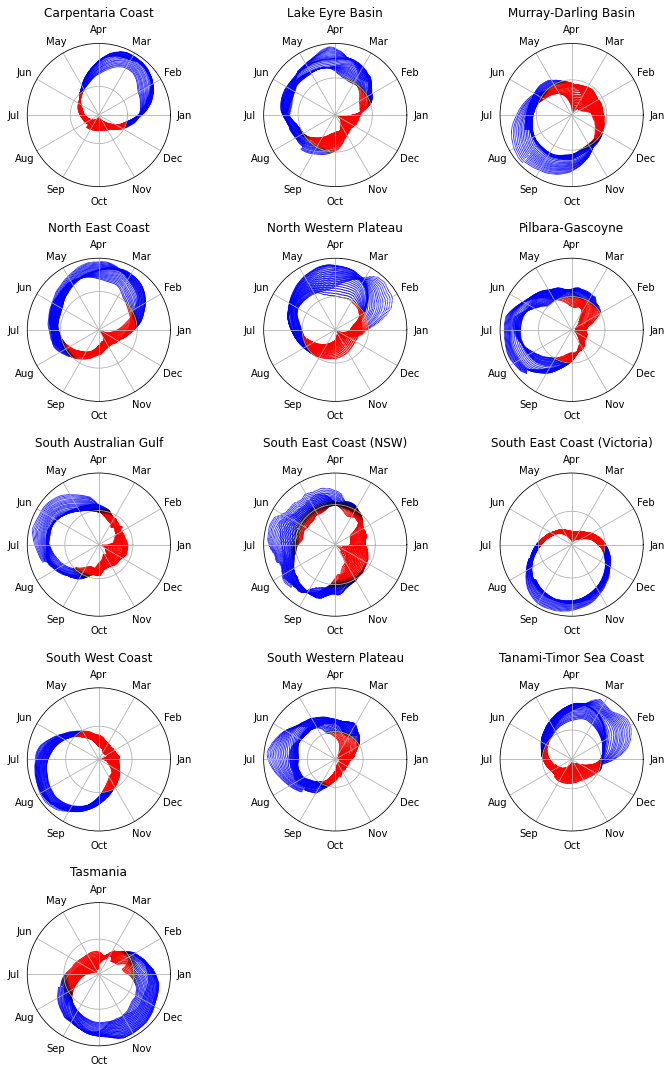

In [155]:
plt.figure(figsize=(10, 15))
for i in range(13):
    ax = plt.subplot(5, 3, i + 1, projection='polar')
    ax.set_title(divisions[i], pad=20)
    grad = np.gradient(area_weighted_means[divisions[i]])
    days = dates.dayofyear
    angles = days / 365 * 2 * np.pi
    season = stl_results[divisions[i]].seasonal
    ax.scatter(angles, season, alpha=1, s=1, edgecolor='None', c=season, cmap=matplotlib.colors.LinearSegmentedColormap.from_list('rkb', ['r', 'k', 'b']), vmax=0.5, vmin=-0.5)
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_rticks([0])
    ax.set_yticklabels([''])
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

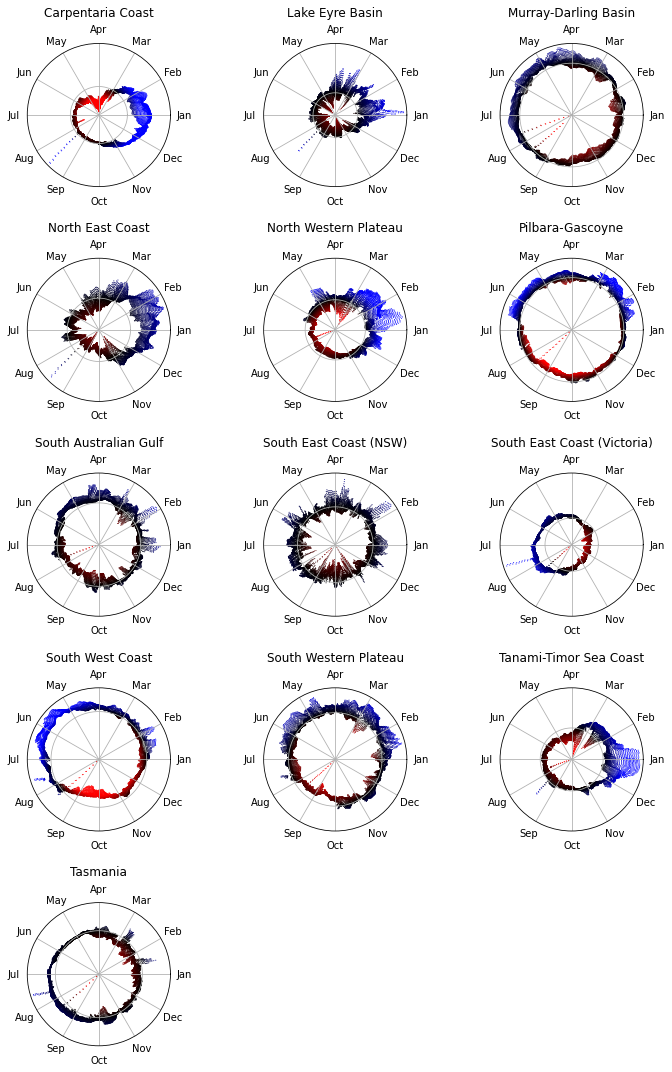

In [239]:
plt.figure(figsize=(10, 15))
for i in range(13):
    ax = plt.subplot(5, 3, i + 1, projection='polar')
    ax.set_title(divisions[i], pad=20)
    grad = np.gradient(area_weighted_means[divisions[i]])
    days = dates.dayofyear
    angles = days / 365 * 2 * np.pi
    season = np.gradient(stl_results[divisions[i]].seasonal)
    ax.scatter(angles, season, alpha=1, s=1, edgecolor='None', c=season, cmap=matplotlib.colors.LinearSegmentedColormap.from_list('rkb', ['r', 'k', 'b']), vmax=0.25, vmin=-0.25)
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_rticks([0])
    ax.set_yticklabels([''])
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

Let's search for climate driver trends in the residuals. The climate drivers form a vector time series in $\mathbb N \to \mathbb R^3$. We have observations $\vec w \in \mathbb R^{T \times N}$ where $T = 12391$ days and $N$ is the number of waterbodies or time series, which we can interpret as another vector time series $\mathbb N \to \mathbb R^N$. This could be modelled by a sequence-to-sequence model.